In [4]:
import json
import glob, pickle

import numpy as np
import pandas
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
plt.style.use({'figure.facecolor':'white'})

In [2]:
backend_lima = FakeLima()
backend_belem = FakeBelem()
backend_montreal = FakeMontreal()
properties_lima = get_backend_properties_v1(backend_lima)
properties_belem = get_backend_properties_v1(backend_belem)
properties_montreal = get_backend_properties_v1(backend_montreal)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_lima = AerSimulator.from_backend(backend_lima) # Noisy
backend_noisy_belem = AerSimulator.from_backend(backend_belem) # Noisy
backend_noisy_montreal = AerSimulator.from_backend(backend_montreal) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_lima = {'shots': 10000, 'backend': backend_noisy_lima, 'name': 'noisy_lima'}
run_config_noisy_belem = {'shots': 10000, 'backend': backend_noisy_belem, 'name': 'noisy_belem'}
run_config_noisy_montreal = {'shots': 10000, 'backend': backend_noisy_montreal, 'name': 'noisy_montreal'}

BATCH_SIZE = 32

In [3]:
properties_lima.keys()

dict_keys(['name', 'gates_set', 'num_qubits', 'qubits_props', 'gate_props'])

In [4]:
properties_lima['gate_props']

{'id_0': {'index': 'id_0',
  'gate_error': 0.00019195510390342677,
  'gate_length': 35.55555555555556},
 'id_1': {'index': 'id_1',
  'gate_error': 0.00033064681663890665,
  'gate_length': 35.55555555555556},
 'id_2': {'index': 'id_2',
  'gate_error': 0.0001807726361160903,
  'gate_length': 35.55555555555556},
 'id_3': {'index': 'id_3',
  'gate_error': 0.0003925363414603665,
  'gate_length': 35.55555555555556},
 'id_4': {'index': 'id_4',
  'gate_error': 0.0006789531879417325,
  'gate_length': 35.55555555555556},
 'rz_0': {'index': 'rz_0', 'gate_error': 0, 'gate_length': 0},
 'rz_1': {'index': 'rz_1', 'gate_error': 0, 'gate_length': 0},
 'rz_2': {'index': 'rz_2', 'gate_error': 0, 'gate_length': 0},
 'rz_3': {'index': 'rz_3', 'gate_error': 0, 'gate_length': 0},
 'rz_4': {'index': 'rz_4', 'gate_error': 0, 'gate_length': 0},
 'sx_0': {'index': 'sx_0',
  'gate_error': 0.00019195510390342677,
  'gate_length': 35.55555555555556},
 'sx_1': {'index': 'sx_1',
  'gate_error': 0.0003306468166389066

In [27]:
def compare_backends(b1, b2, q1, q2):
    assert len(q1) == len(q2)
    diff_percent = []
    diff = []

    qubit_props_b1 = [b1['qubits_props'][i] for i in q1]
    qubit_props_b2 = [b2['qubits_props'][i] for i in q2]
    for key in ['readout_error']:
        for i in range(len(q1)):
            diff_percent += [abs(qubit_props_b1[i][key] - qubit_props_b2[i][key]) / qubit_props_b1[i][key]]
            diff += [abs(qubit_props_b1[i][key] - qubit_props_b2[i][key])]

    gates_b1 = [f'sx_{q}' for q in q1] + [f'x_{q}' for q in q1] + [f'cx_{i}_{j}' for i in q1 for j in q1 if i != j]
    gates_b2 = [f'sx_{q}' for q in q2] + [f'x_{q}' for q in q2] + [f'cx_{i}_{j}' for i in q2 for j in q2 if i != j]
    for key1, key2 in zip(gates_b1, gates_b2):
        try:
            diff_percent += [abs(b1['gate_props'][key1]['gate_error'] - b2['gate_props'][key2]['gate_error']) / b1['gate_props'][key1]['gate_error']]
            diff += [abs(b1['gate_props'][key1]['gate_error'] - b2['gate_props'][key2]['gate_error'])]
        except KeyError as e:
            print('No gate', e)

    return diff, diff_percent

q1 = q2 = list(range(5))
diff, diff_percent = compare_backends(properties_lima, properties_belem, q1, q2)
print(np.mean(diff), np.std(diff))
print(np.mean(diff_percent), np.std(diff_percent))

No gate 'cx_0_2'
No gate 'cx_0_3'
No gate 'cx_0_4'
No gate 'cx_1_4'
No gate 'cx_2_0'
No gate 'cx_2_3'
No gate 'cx_2_4'
No gate 'cx_3_0'
No gate 'cx_3_2'
No gate 'cx_4_0'
No gate 'cx_4_1'
No gate 'cx_4_2'
0.0059299205139710185 0.0082653308353876
0.5306288980423092 0.23227923520092497


In [25]:
def compare_backends(b1, b2, q1, q2):
    assert len(q1) == len(q2)
    diff_percent = []
    diff = []

    qubit_props_b1 = [b1['qubits_props'][i] for i in q1]
    qubit_props_b2 = [b2['qubits_props'][i] for i in q2]
    for key in ['t1', 't2']:
        for i in range(len(q1)):
            diff_percent += [abs(qubit_props_b1[i][key] - qubit_props_b2[i][key]) / qubit_props_b1[i][key]]
            diff += [abs(qubit_props_b1[i][key] - qubit_props_b2[i][key])]

    return diff, diff_percent

q1 = q2 = list(range(5))
diff, diff_percent = compare_backends(properties_lima, properties_montreal, q1, q2)
print(np.mean(diff), np.std(diff))
print(np.mean(diff_percent), np.std(diff_percent))

5.365487374858677e-05 5.009250950106034e-05
1.9933045214958696 3.247128977179777


# Overtime

In [143]:
backend_name = 'lima'
path = f'./device_params/ibmq_{backend_name}_params.json'

with open(path, 'r') as in_file:
    params = json.load(in_file)

params = params[f'ibmq_{backend_name}']
params.keys()

dict_keys(['times', 't1', 't2', 'readout_err', 'cnot_err', 'sx_err', 'x_err'])

In [147]:
import pandas as pd

df = pd.DataFrame.from_dict(params['times'])
df['times'] = pd.to_datetime(df[0], infer_datetime_format=True)
df = df.drop(0, axis=1)
q_indices = list(map(str, np.arange(5)))
for prop in ['t1', 't2', 'readout_err', 'sx_err', 'x_err']:
    for ind in q_indices:
        df[prop+'_q'+ind] = params[prop][ind]

q_pair_indices = list(params['cnot_err'].keys())
for ind_pair in q_pair_indices:
    df['cx_'+ind_pair] = params['cnot_err'][ind_pair]

In [148]:
df_pct_change = df.drop(['times'], axis=1).pct_change(periods=1)
df_pct_change = df_pct_change.loc[~(df_pct_change==0).all(axis=1)]
df = df.iloc[df_pct_change.index, :]

In [149]:
len(df)

15

In [150]:
df_pct_change = df.drop(['times'], axis=1).pct_change().abs()
df_pct_change = df_pct_change.join(df.times)
df_pct_change['delta'] = (df_pct_change['times']-df_pct_change['times'].shift())#.fillna(0)
df_pct_change = df_pct_change.dropna()
dfs = df_pct_change

for p in range(1, 250):
    df_pct_change = df.drop(['times'], axis=1).pct_change(periods=p).abs()
    df_pct_change = df_pct_change.join(df.times)
    df_pct_change['delta'] = (df_pct_change['times']-df_pct_change['times'].shift(p))#.fillna(0)
    df_pct_change = df_pct_change.dropna()
    dfs = pd.concat([dfs, df_pct_change])

In [151]:
dfs

,t1_q0,t1_q1,t1_q2,t1_q3,t1_q4,t2_q0,t2_q1,t2_q2,t2_q3,t2_q4,...,cx_0_1,cx_1_0,cx_1_2,cx_1_3,cx_2_1,cx_3_1,cx_3_4,cx_4_3,times,delta
3,0.234876,0.199979,0.100959,0.370254,0.128081,0.103538,0.152720,0.252724,0.708810,0.030456,...,1.983011,1.983011,0.117996,0.191899,0.117996,0.191899,0.147803,0.147803,2023-02-16 02:08:57,0 days 09:00:00
11,0.188652,0.173726,0.035532,0.010539,0.112081,0.121949,0.114759,0.025730,0.763618,0.017027,...,0.647345,0.647345,0.003902,0.075462,0.003902,0.075462,0.045144,0.045144,2023-02-17 02:08:57,1 days 00:00:00
20,0.188230,0.167579,0.269973,1.021594,0.003914,0.397811,0.113394,0.021635,0.410587,0.026839,...,1.421088,1.421088,0.237006,0.312892,0.237006,0.312892,0.016130,0.016130,2023-02-18 05:08:57,1 days 03:00:00
27,0.032040,0.226958,0.459038,0.142273,0.037863,0.171426,0.348772,0.567394,0.612116,0.032118,...,0.587302,0.587302,0.044044,0.270045,0.044044,0.270045,0.027877,0.027877,2023-02-19 02:08:57,0 days 21:00:00
35,0.123621,0.180175,0.772845,0.180660,0.114144,0.467701,0.026341,0.542948,0.014547,0.012417,...,1.747321,1.747321,0.116414,0.025990,0.116414,0.025990,0.056676,0.056676,2023-02-20 02:08:57,1 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.065779,0.072810,0.373392,0.989894,0.039516,0.243342,0.414806,0.184330,2.824812,0.026474,...,0.380147,0.380147,0.920845,0.086519,0.920845,0.086519,0.072425,0.072425,2023-03-01 02:08:57,13 days 00:00:00
115,0.190190,0.635872,0.128375,0.747460,0.126599,0.178516,0.120173,0.298247,1.113860,0.028694,...,0.864951,0.864951,0.797828,0.226225,0.797828,0.226225,0.149233,0.149233,2023-03-02 02:08:57,13 days 00:00:00
107,0.153648,0.258228,0.310130,0.253129,0.093627,0.114609,0.325435,0.114979,0.113748,0.056123,...,0.849030,0.849030,1.147497,0.121983,1.147497,0.121983,0.209523,0.209523,2023-03-01 02:08:57,13 days 09:00:00
115,0.034342,0.572613,0.097405,0.729043,0.028707,0.034797,0.221141,0.331650,2.728042,0.045233,...,0.342316,0.342316,0.804843,0.133691,0.804843,0.133691,0.187639,0.187639,2023-03-02 02:08:57,14 days 00:00:00


In [152]:
df_almost = dfs.groupby('delta').agg('mean')

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_27126/2179848643.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_almost = dfs.groupby('delta').agg('mean')


In [153]:
keys = [f't{k}_q'+ind for ind in q_indices for k in [1, 2]]
df_almost['t'] = df_almost[keys].mean(axis=1)
df_almost['t_ste'] = df_almost[keys].std(axis=1) / np.sqrt(len(df.columns))
keys = df_almost.columns
keys = [x for x in keys if not x.startswith('t')]
df_almost['e'] = df_almost[keys].mean(axis=1)
df_almost['e_ste'] = df_almost[keys].std(axis=1) / np.sqrt(len(df.columns))

In [154]:
df_almost

,t1_q0,t1_q1,t1_q2,t1_q3,t1_q4,t2_q0,t2_q1,t2_q2,t2_q3,t2_q4,...,cx_1_2,cx_1_3,cx_2_1,cx_3_1,cx_3_4,cx_4_3,t,t_ste,e,e_ste
delta,,,,,,,,,,,,,,,,,,,,,
0 days 09:00:00,0.147033,0.240336,0.169073,0.240613,0.150782,0.051769,0.076360,0.126362,0.354405,0.015228,...,0.337363,0.166566,0.337363,0.166566,0.073902,0.073902,0.157196,0.017321,0.376443,0.080252
0 days 15:00:00,0.509503,0.043249,0.232366,0.162563,0.043223,0.320757,0.215706,0.330784,0.050521,0.048144,...,0.087033,0.117141,0.087033,0.117141,0.018970,0.018970,0.195682,0.027089,0.258771,0.059406
0 days 21:00:00,0.061739,0.153169,0.473203,0.085929,0.045762,0.114492,0.185397,0.525061,0.339162,0.041779,...,0.038498,0.160628,0.038498,0.160628,0.090298,0.090298,0.202569,0.030799,0.154564,0.024194
1 days 00:00:00,0.283181,0.210892,0.689158,0.108600,0.075964,0.499920,0.166738,0.273314,0.203084,0.064258,...,0.079751,0.056128,0.079751,0.056128,0.052686,0.052686,0.257511,0.033909,0.231764,0.044931
1 days 03:00:00,0.172192,0.283211,0.163633,0.601607,0.041344,0.397391,0.068829,0.022775,0.220238,0.124873,...,0.180946,0.249691,0.180946,0.249691,0.071627,0.071627,0.209609,0.030689,0.359258,0.071245
1 days 09:00:00,0.217610,0.112364,0.191696,0.188917,0.058587,0.921026,0.056143,0.127152,0.367214,0.023643,...,0.297619,0.143587,0.297619,0.143587,0.097731,0.097731,0.226435,0.045235,0.194835,0.022297
1 days 15:00:00,0.199654,0.082256,0.123318,0.008417,0.035146,0.288076,0.108993,0.240833,0.129526,0.225513,...,0.101935,0.104880,0.101935,0.104880,0.003688,0.003688,0.144173,0.015737,0.273437,0.058207
1 days 21:00:00,0.151700,0.087676,0.668572,0.064090,0.080603,0.376452,0.384300,0.283619,0.635567,0.020100,...,0.077497,0.289017,0.077497,0.289017,0.086133,0.086133,0.275268,0.040615,0.212876,0.032525
2 days 00:00:00,0.388072,0.189351,0.644802,0.344939,0.052948,0.809456,0.137307,0.417186,0.313768,0.094093,...,0.245084,0.060048,0.245084,0.060048,0.074600,0.074600,0.339192,0.041575,0.330937,0.064408


In [155]:
df_almost = df_almost.reset_index()
df_almost['delta'] = df_almost['delta'].dt.total_seconds() / 3600
df_almost = df_almost.set_index('delta')
df_almost[['t', 't_ste', 'e', 'e_ste']]

,t,t_ste,e,e_ste
delta,,,,
9.0,0.157196,0.017321,0.376443,0.080252
15.0,0.195682,0.027089,0.258771,0.059406
21.0,0.202569,0.030799,0.154564,0.024194
24.0,0.257511,0.033909,0.231764,0.044931
27.0,0.209609,0.030689,0.359258,0.071245
33.0,0.226435,0.045235,0.194835,0.022297
39.0,0.144173,0.015737,0.273437,0.058207
45.0,0.275268,0.040615,0.212876,0.032525
48.0,0.339192,0.041575,0.330937,0.064408


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_27126/3937031811.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(x)*100) for x in labels])


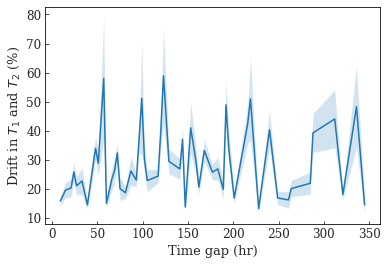

In [166]:
import matplotlib
import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']
# mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['text.usetex'] = False
mpl.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('axes',edgecolor='black')
plt.style.use({'figure.facecolor':'white'})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font', weight='normal')
fs = 13

plt.plot(df_almost['t'])
plt.fill_between(df_almost.index, df_almost['t']-df_almost['t_ste'], df_almost['t']+df_almost['t_ste'], alpha=0.2)
ax = plt.gca()
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels([int(float(x)*100) for x in labels])
plt.ylabel(r'Drift in $T_1$ and $T_2$ (%)', fontsize=fs)
plt.xlabel('Time gap (hr)', fontsize=fs)
ax.grid(False)
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='y',direction='in')
ax.tick_params(axis='x',direction='in')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("./device_params/ibmq_lima_t1_t2.pdf", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_27126/3479601704.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(x)*100) for x in labels])


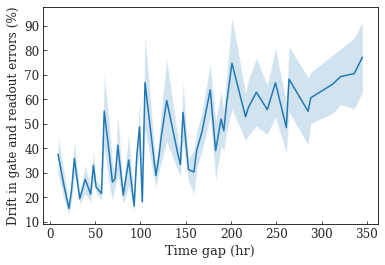

In [170]:
import matplotlib
import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']
# mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['text.usetex'] = False
mpl.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('axes',edgecolor='black')
plt.style.use({'figure.facecolor':'white'})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font', weight='normal')
fs = 13

plt.style.use({'figure.facecolor':'white'})
plt.plot(df_almost['e'])
plt.fill_between(df_almost.index, df_almost['e']-df_almost['e_ste'], df_almost['e']+df_almost['e_ste'], alpha=0.2)
ax = plt.gca()
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels([int(float(x)*100) for x in labels])
plt.ylabel('Drift in gate and readout errors (%)', fontsize=fs-1)
plt.xlabel('Time gap (hr)', fontsize=fs)
ax.grid(False)
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax.tick_params(axis='y',direction='in')
ax.tick_params(axis='x',direction='in')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("./device_params/ibmq_lima_gate_readout_errors.pdf", dpi=300, bbox_inches='tight', transparent=True)

plt.show()